# Config

In [1]:
# Data analysis and wrangling
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge

# Data

In [2]:
# mmm_input.csv를 읽어와서 학습에 필요없는 열인 H2/CH4를 제거
df = pd.read_csv("mmm_input.csv")
# df.style.hide_index()  # 이거 pandas version 1.4 이상부턴 deprecated돼서 고쳐야함 일단 keep
df.drop(["H2/CH4"], axis=1, inplace=True)

# MMM column을 분리해서 output data를 생성
x_data = df.loc[:, ["Inorganic", "Polymer"]]
y_data = df.loc[:, ["MMM"]]

In [3]:
x_data.head()

,Inorganic,Polymer
0,280.0,154.00
1,280.0,201.00
2,280.0,0.13
3,280.0,20.00
4,280.0,5.55


In [4]:
y_data.head()

,MMM
0,227.333333
1,269.345894
2,0.246885
3,35.625000
4,10.343953


In [5]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Inorganic  180 non-null    float64
 1   Polymer    180 non-null    float64
dtypes: float64(2)
memory usage: 2.9 KB


수집한 180개의 데이터 모두 non-null임을 알 수 있으므로 결측치 처리는 해줄 필요가 없음을 알 수 있다.

In [6]:
x_data.describe()

,Inorganic,Polymer
count,180.000000,180.000000
mean,236.512667,4324.729333
std,664.368189,8080.120495
min,0.482000,0.130000
25%,5.895000,20.000000
50%,13.500000,154.000000
75%,29.050000,3300.000000
max,2420.000000,23200.000000


~~pd.describe()를 통해 각 feature의 대략적인 distribution과 interquartile range를 알 수 있다. 위에서 보다시피 inorganic과 Polymer의 data scale이 다르므로 Min-Max Normalization을 통해 [0, 1]로 normalize한다.~~

~~Min-Max Normalization은 회귀 모델에 유용하지만 outlier에 매우 민감하므로 boxplot을 그려 outlier 여부를 확인하고 이를 처리하는 작업이 필요하다.~~

현재 Normalization 안한 상태

<AxesSubplot:ylabel='Inorganic'>

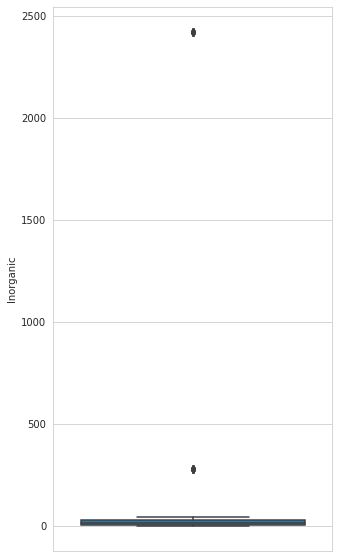

In [7]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(5, 10))
sns.boxplot(y=x_data["Inorganic"])

<AxesSubplot:ylabel='Polymer'>

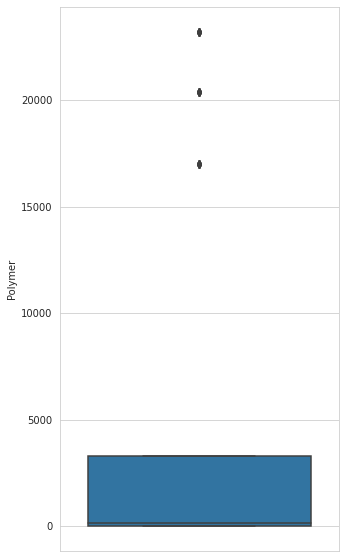

In [8]:
fig = plt.figure(figsize=(5, 10))
sns.boxplot(y=x_data["Polymer"])

위 그림에서 점으로 표현된 것이 outlier이다. outlier를 처리하는 방법으로는 아예 제거하는 방법 또는 평균이나 최빈값으로 대체하는 방법 등이 있다.

input data를 살펴보면 outlier의 개수가 feature마다 다르고 애초에 train size가 1000도 넘지 못할 정도로 매우 작다. 그리고 input_data에서 inorganic과 Polymer 값이 변화에 따른 MMM 값을 관찰한 결과 linear relationship을 가지는 간단한 모델이 이를 설명할 수 있음을 직관적으로 알 수 있다. 

In [9]:
q1 = x_data["Inorganic"].quantile(0.25)
q3 = x_data["Inorganic"].quantile(0.75)
iqr = q3 - q1
print(iqr)

condition = x_data["Inorganic"] > q3 + 1.5 * iqr
print(x_data[condition])

target = x_data[condition].index
x_data.drop(target, inplace=True)
y_data.drop(target, inplace=True)
print(x_data)

23.155
    Inorganic   Polymer
0       280.0    154.00
1       280.0    201.00
2       280.0      0.13
3       280.0     20.00
4       280.0      5.55
5       280.0     13.06
6       280.0     76.20
7       280.0     52.00
8       280.0    106.00
9       280.0    156.00
10      280.0    187.00
11      280.0   3300.00
12      280.0  17000.00
13      280.0  20400.00
14      280.0  23200.00
60     2420.0    154.00
61     2420.0    201.00
62     2420.0      0.13
63     2420.0     20.00
64     2420.0      5.55
65     2420.0     13.06
66     2420.0     76.20
67     2420.0     52.00
68     2420.0    106.00
69     2420.0    156.00
70     2420.0    187.00
71     2420.0   3300.00
72     2420.0  17000.00
73     2420.0  20400.00
74     2420.0  23200.00
     Inorganic   Polymer
15        11.0    154.00
16        11.0    201.00
17        11.0      0.13
18        11.0     20.00
19        11.0      5.55
..         ...       ...
175       16.0    187.00
176       16.0   3300.00
177       16.0  17000.00

In [10]:
q1 = x_data["Polymer"].quantile(0.25)
q3 = x_data["Polymer"].quantile(0.75)
iqr = q3 - q1
print(iqr)

condition = x_data["Polymer"] > q3 + 1.5 * iqr
print(x_data[condition])

target = x_data[condition].index
x_data.drop(target, inplace=True)
y_data.drop(target, inplace=True)
print(x_data)

3280.0
     Inorganic  Polymer
27      11.000  17000.0
28      11.000  20400.0
29      11.000  23200.0
42       9.000  17000.0
43       9.000  20400.0
44       9.000  23200.0
57      19.300  17000.0
58      19.300  20400.0
59      19.300  23200.0
87       5.460  17000.0
88       5.460  20400.0
89       5.460  23200.0
102      6.040  17000.0
103      6.040  20400.0
104      6.040  23200.0
117     23.000  17000.0
118     23.000  20400.0
119     23.000  23200.0
132     47.200  17000.0
133     47.200  20400.0
134     47.200  23200.0
147      0.670  17000.0
148      0.670  20400.0
149      0.670  23200.0
162      0.482  17000.0
163      0.482  20400.0
164      0.482  23200.0
177     16.000  17000.0
178     16.000  20400.0
179     16.000  23200.0
     Inorganic  Polymer
15        11.0   154.00
16        11.0   201.00
17        11.0     0.13
18        11.0    20.00
19        11.0     5.55
..         ...      ...
172       16.0    52.00
173       16.0   106.00
174       16.0   156.00
175      

# Model

우리가 하려는 일은 categorical하게 분류된 것이 아닌 어떤 특정한 float 값을 구하는 것이 목적이기 때문에 이 문제는 Regression으로 정의할 수 있다.

scikit learn에서 제공하는 Choosing the right estimator 그림(https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)에 따르면 우리가 사용할 수 있는 모델은 RidgeRegression과 SVR(kernal="rbf")가 있는데 위에서 언급했다시피 모델이 간단할 것으로 예측되기 때문에 우선은 RidgeRegression을 baseline model로 채택하였다.

~~input data로 사용한 두 feature의 중요도가 비슷하다는 것이 RidgeRegression일 거라는 주장을 뒷받침만할 또다른 근거가 될 수 있다(확인 필요)~~

In [11]:
# train set과 test set의 비율을 8:2로 나눠줌
# random_state를 고정시켜두어 반복해서 실험했을 때도 같은 결과가 나오게끔 해줌
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=123)

print(x_train)
print(x_test)
print(y_train)
print(y_test)

     Inorganic  Polymer
95       6.040    13.06
49      19.300     5.55
77       5.460     0.13
37       9.000    52.00
159      0.482   156.00
..         ...      ...
156      0.482    76.20
152      0.482     0.13
143      0.670   106.00
111     23.000    76.20
166     16.000   201.00

[96 rows x 2 columns]
     Inorganic  Polymer
19      11.000     5.55
174     16.000   156.00
169     16.000     5.55
158      0.482   106.00
52      19.300    52.00
45      19.300   154.00
167     16.000     0.13
107     23.000     0.13
34       9.000     5.55
56      19.300  3300.00
54      19.300   156.00
23      11.000   106.00
20      11.000    13.06
15      11.000   154.00
31       9.000   201.00
125     47.200    13.06
138      0.670    20.00
93       6.040    20.00
145      0.670   187.00
120     47.200   154.00
50      19.300    13.06
136      0.670   201.00
110     23.000    13.06
98       6.040   106.00
            MMM
95    14.737170
49     8.619844
77     0.254091
37    53.334513
159  164.

In [12]:
# Ridge regression
model = Ridge()

# Train

In [13]:
model.fit(x_train, y_train)

Ridge()

# Evaluation

In [14]:
train_score = model.score(x_train, y_train)
test_score = model.score(x_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.9987207087613424
Test score: 0.9946161400384905


예상대로 정확도가 매우 높게 나옴을 알 수 있다.

# Inference

In [15]:
# 우리가 위에서 모델을 평가할 때 사용한 test data를 이용해서 mmm 값을 구한 예시
# 현재 mmm의 예측 결과로 음수가 나오는 issue가 발생함 input_data로 추론해보건대 음수가 나오면 안될것 같은데 이거 해결 필요

y_pred = model.predict(x_test)
mmm_pred = np.hstack([x_test, y_pred])  # test data와 우리가 학습한 모델을 통해 예측된 mmm 값을 가로로 이어붙임
mmm_pred = pd.DataFrame(mmm_pred, columns=["Inorganic", "Polymer", "predicted MMM"])
print(mmm_pred)

    Inorganic  Polymer  predicted MMM
0      11.000     5.55       7.523100
1      16.000   156.00     162.605095
2      16.000     5.55       9.470842
3       0.482   106.00     105.668007
4      19.300    52.00      58.035090
5      19.300   154.00     161.854922
6      16.000     0.13       3.954141
7      23.000     0.13       6.680981
8       9.000     5.55       6.744003
9      19.300  3300.00    3363.984257
10     19.300   156.00     163.890605
11     11.000   106.00     109.765278
12     11.000    13.06      15.167089
13     11.000   154.00     158.621669
14      9.000   201.00     205.681123
15     47.200    13.06      29.268745
16      0.670    20.00      18.206873
17      6.040    20.00      20.298749
18      0.670   187.00     188.186403
19     47.200   154.00     172.723325
20     19.300    13.06      18.400342
21      0.670   201.00     202.436184
22     23.000    13.06      19.841672
23      6.040   106.00     107.833117


In [16]:
def get_alpha(inorganic, polymer):
    print(inorganic / polymer)

mmm_pred_np = mmm_pred.to_numpy()[:, :2]

for row in mmm_pred_np:
    get_alpha(row[0], row[1])

1.981981981981982
0.10256410256410256
2.882882882882883
0.004547169811320755
0.37115384615384617
0.12532467532467534
123.07692307692307
176.9230769230769
1.6216216216216217
0.0058484848484848485
0.12371794871794872
0.10377358490566038
0.8422664624808576
0.07142857142857142
0.04477611940298507
3.614088820826953
0.0335
0.302
0.0035828877005347594
0.3064935064935065
1.4777947932618682
0.0033333333333333335
1.7611026033690658
0.056981132075471695
